In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import datetime
import string
from string import digits
import collections
import scipy.stats as scs
import cc_pipeline as P
import time
import random
import pickle
from pprint import pprint
from collections import Counter
import itertools

#sentiment and language
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
import vaderSentiment
from langdetect import detect
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from spacy import displacy

#machine learning
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import chi2
import knee_locator

#plotting
from bokeh.plotting import figure, show, output_file, output_notebook, ColumnDataSource
from bokeh.models import HoverTool, BoxSelectTool
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
# import pyLDAvis.sklearn
# import pyLDAvis
#import umap

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/Beto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Beto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Beto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## TV Captions - Unsupervised Machine Learning and NLP

## Data Structure

In [22]:
df = pd.read_csv('data/captions_.csv', encoding='utf=8')
df.head()

,_id,channel,created_at,duration,lang,machine_id,ts,tui,tv,url,zip_url,date,text,cleaned,language,stations
0,{'$oid': '5bb2b5082c1ba60007fc013d'},WBNX_HD_CW,{'$date': '2018-10-02T00:00:08.982Z'},900000,dflt,ENSWERCCR7_8_3,{'$numberLong': '1538437500000'},251536767,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:08.982,1538437621406\n1835\n[ KNOCK ON DOOR ]\n\n1538...,knock door knew only that still knock have doo...,en,WBNX HD CW
1,{'$oid': '5bb2b5106f40ed000728b879'},KZJO_MY_NETWORK_SEATTLE,{'$date': '2018-10-02T00:00:16.702Z'},900000,dflt,ENSWERCCR7_48_2,{'$numberLong': '1538437500000'},251533435,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:16.702,"1538437521225\n1435\nSeen it, covered it.\n\n1...",seen covered know thing seen thing farmer burk...,en,KZJO MY NETWORK SEATTLE
2,{'$oid': '5bb2b51170969a000bc9a14e'},WVUA_THIS_TV_BIRMINGHAM,{'$date': '2018-10-02T00:00:17.995Z'},900000,dflt,ENSWERCCR7_65_236,{'$numberLong': '1538435700000'},251541606,{'$date': '2018-10-01T23:15:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.995,1538435707355\n4571\n\n\n\n1538435711926\n23...,look your traffic report look your traffic rep...,en,WVUA THIS TV BIRMINGHAM
3,{'$oid': '5bb2b51187701400079ec41d'},TV_LAND,{'$date': '2018-10-02T00:00:17.925Z'},900000,dflt,ENSWERCCR4_22,{'$numberLong': '1538437500000'},251536903,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.925,1538437500869\n2653\nWe’ll talk later.\n\n1538...,talk later right back verdict sidney guess som...,en,TV LAND
4,{'$oid': '5bb2b511b18af90007b4e445'},WPCH_INDEPENDENT_ATLANTA,{'$date': '2018-10-02T00:00:17.074Z'},900000,dflt,ENSWERCCR7_7_245,{'$numberLong': '1538437500000'},251534109,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.074,1538437500144\n1201\nIt hurts.\n\n153843750218...,hurt heart lost murr kid friend play video gam...,en,WPCH INDEPENDENT ATLANTA


## Extracting Text

In [ ]:
#text extract function

from socket import error as SocketError
import errno

def scrape_text(series):
    
    #use pd.series 
    text = []
    for link in series:
        
        try:
            req = Request(link, headers={'User-Agent': 'Mozilla/5.0'})
            webpage = urlopen(req).read()
            webpage = webpage.decode('utf-8')
            text.append(webpage)
        except SocketError as e:
            if e.errno != errno.ECONNRESET:
                raise 
            pass 
        
    return text

In [ ]:
#scrape at intervals

def scrape_from_url(cycles):
    
    for i in range(cycles):
        
        time.sleep(900)
        
        from_df = pd.read_csv('data/cc_recent.csv', encoding='utf-8')
        temp_df = from_df.head(1000)

        #scrape text then concat
        text_url_series = pd.Series(temp_df['url'])
        extracts = scrape_text(text_url_series)
        extracts = pd.Series(extracts)
        temp_df['text'] = extracts

        head_df = pd.read_csv('data/cc_head_text.csv', encoding='utf-8')
        head_df = pd.concat([head_df, temp_df])
        head_df.to_csv('data/cc_head_text.csv', encoding='utf-8', index=False)

        from_df = from_df.drop(from_df.index[0:1000])
        from_df.to_csv('data/cc_recent.csv', encoding='utf-8', index=False)

        head_df=None
        temp_df=None
        from_df=None
        text_url_series=None
        extracts=None

## Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51973 entries, 0 to 51972
Data columns (total 16 columns):
_id           51973 non-null object
channel       51973 non-null object
created_at    51973 non-null object
duration      51973 non-null int64
lang          51973 non-null object
machine_id    51973 non-null object
ts            51973 non-null object
tui           51973 non-null int64
tv            51973 non-null object
url           51973 non-null object
zip_url       51973 non-null object
date          51973 non-null object
text          51973 non-null object
cleaned       51973 non-null object
language      51973 non-null object
stations      51973 non-null object
dtypes: int64(2), object(14)
memory usage: 6.3+ MB


In [5]:
df.describe()

,duration,tui
count,51973.0,5.197300e+04
mean,900000.0,2.547169e+08
std,0.0,2.127712e+07
min,900000.0,2.515332e+08
25%,900000.0,2.515362e+08
50%,900000.0,2.515387e+08
75%,900000.0,2.515463e+08
max,900000.0,4.106483e+08


In [68]:
df['stations'][:50]

0                        WBNX HD CW
1           KZJO MY NETWORK SEATTLE
2           WVUA THIS TV BIRMINGHAM
3                           TV LAND
4          WPCH INDEPENDENT ATLANTA
5               KOB NBC ALBUQUERQUE
6                 KATU ABC PORTLAND
7                    KTUL ABC TULSA
8                     ABC FAMILY HD
9     INVESTIGATION DISCOVERY ID HD
10              WHAS ABC LOUISVILLE
11         CNN HEADLINE NEWS HLN SD
12                    TRUTV EAST HD
13            WTTA MY NETWORK TAMPA
14                DISNEY CHANNEL HD
15                      CBS KCBS HD
16                      ABC KABC HD
17    WDCA MY NETWORK WASHINGTON DC
18                     KTVX ABC SLC
19                    BRAVO EAST HD
20                  KMGH ABC DENVER
21                   KWGN CW DENVER
22                  KDVR FOX DENVER
23                      BET EAST SD
24               KVVU FOX LAS VEGAS
25               WBFF FOX BALTIMORE
26                      KSHB NBC KC
27               KSMO MY NET

In [105]:
#raw caption text

print(df['text'][51])

1538437500084
1969
AN UNFORTUNATE
TRAINING EXERCISE

1538437502153
2870
INVOLVING AN F-22 RAPTOR
OCCURRED YESTERDAY.

1538437505122
2536
I AM PLEASED TO REPORT
THAT THE PILOT
WAS NOT INJURED.

1538437507758
5372
AS FOR THE UNEXPECTED
TURN OF EVENTS ON
THE GROUND IN GULMIRA,

1538437513230
2603
IT IS STILL UNCLEAR
WHO OR WHAT INTERVENED,

1538437515933
5772
BUT I CAN ASSURE YOU THAT
THE UNITED STATES GOVERNMENT
WAS NOT INVOLVED.

1538437523174
434
Tony: HEY!

1538437523708
2035
[GROANING]

1538437525843
2669
Jarvis: IT IS
A TIGHT FIT, SIR.

1538437528612
3403
SIR, THE MORE YOU STRUGGLE,
THE MORE THIS IS GOING TO HURT.

1538437532115
2603
BE GENTLE.
THIS IS MY FIRST TIME.

1538437534818
2569
I DESIGNED THIS
TO COME OFF, SO...

1538437537487
1835
[GROANS] HEY.

1538437539422
1802
I REALLY SHOULD BE
ABLE TO...

1538437541325
3737
Jarvis: PLEASE,
TRY NOT TO MOVE, SIR.

1538437545162
2436
WHAT’S GOING ON HERE?

1538437551869
1201
LET’S FACE IT.
THIS IS NOT THE WORST THING
YOU’VE CAUGHT ME DO

In [9]:
#cleaned caption text

print(df['cleaned'][0])

knock door knew only that still knock have doorbell forgive trying save couple buck electricity left nicotine here other night really need since switched those light cigarette that what that thought chiclet that gone explains couldn stop chewing pretty good game want stick around watch guess know other night when talking about spanking think might have taken wrong were pretty clear much open that would look spanked knew know never took well wasn giving fastball just saying nothing didn deserve kid shouldn throwing each other window lighting each other fire stealing stole that dent bonneville that where jimmy landed when tossed window great raising been thinking about really some damage with that hitting fault turned what smart handsome successful know sensitive sensitive mean insensitive vanessa always complaining about something were sensitive could tell what rough result spank your kid that called self control sorry didn mean hurt your feeling know them what talking about remember on

## TF-IDF Vectorization - TruncatedSVD Dimensionality Reduction

In [9]:
text = df['cleaned'].values
text = text.tolist()

In [62]:
def clean_text(doc):
    '''cleans and lemmatizes a string by removing punc, characters, digits, and len(words) < 3'''
    
    stop_words = stopwords.words('english')
    punct = ('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~♪¿’')
    remove_digits = str.maketrans('', '', digits)
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized = []
    
    doc = doc.split('\n')
    doc = ' '.join(doc)
    doc = doc.split('-')
    doc = ' '.join(doc)
    doc = doc.split('...')
    doc = ' '.join(doc)
    doc = ''.join(''.join(s)[:2] for _, s in itertools.groupby(doc))
    doc = word_tokenize(doc)
    
    a = [char for char in doc if char not in punct]
    b = [w for w in a if w not in stop_words] 
    c = [w for w in b if len(w) > 3]
    d = [x for x in c if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]

    e = ' '.join(d)
    f = e.lower()
    g = f.translate(remove_digits)
    cleaned = str(g)
    doc = word_tokenize(cleaned)
    
    for val in doc:
        doc_temp = wordnet_lemmatizer.lemmatize(val)
        lemmatized.append(doc_temp)
    doc = ' '.join(lemmatized)
    
    return doc

def clean_and_return(docs_list):
    
    docs = []
    for cc in docs_list:
        cleaned_temp = clean_text(cc)
        docs.append(cleaned_temp)
        
    return docs

In [63]:
cleaned = clean_and_return(text)

In [13]:
#including n_grams and max features
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), 
                             lowercase=True, ngram_range=(1,3), max_features=1000) 
tfidf_model = vectorizer.fit_transform(text)

#model more robust after including dimensionality reduction prior to KMeans
#n_components=2 for visualization only
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
clf = svd.fit_transform(tfidf_model) 

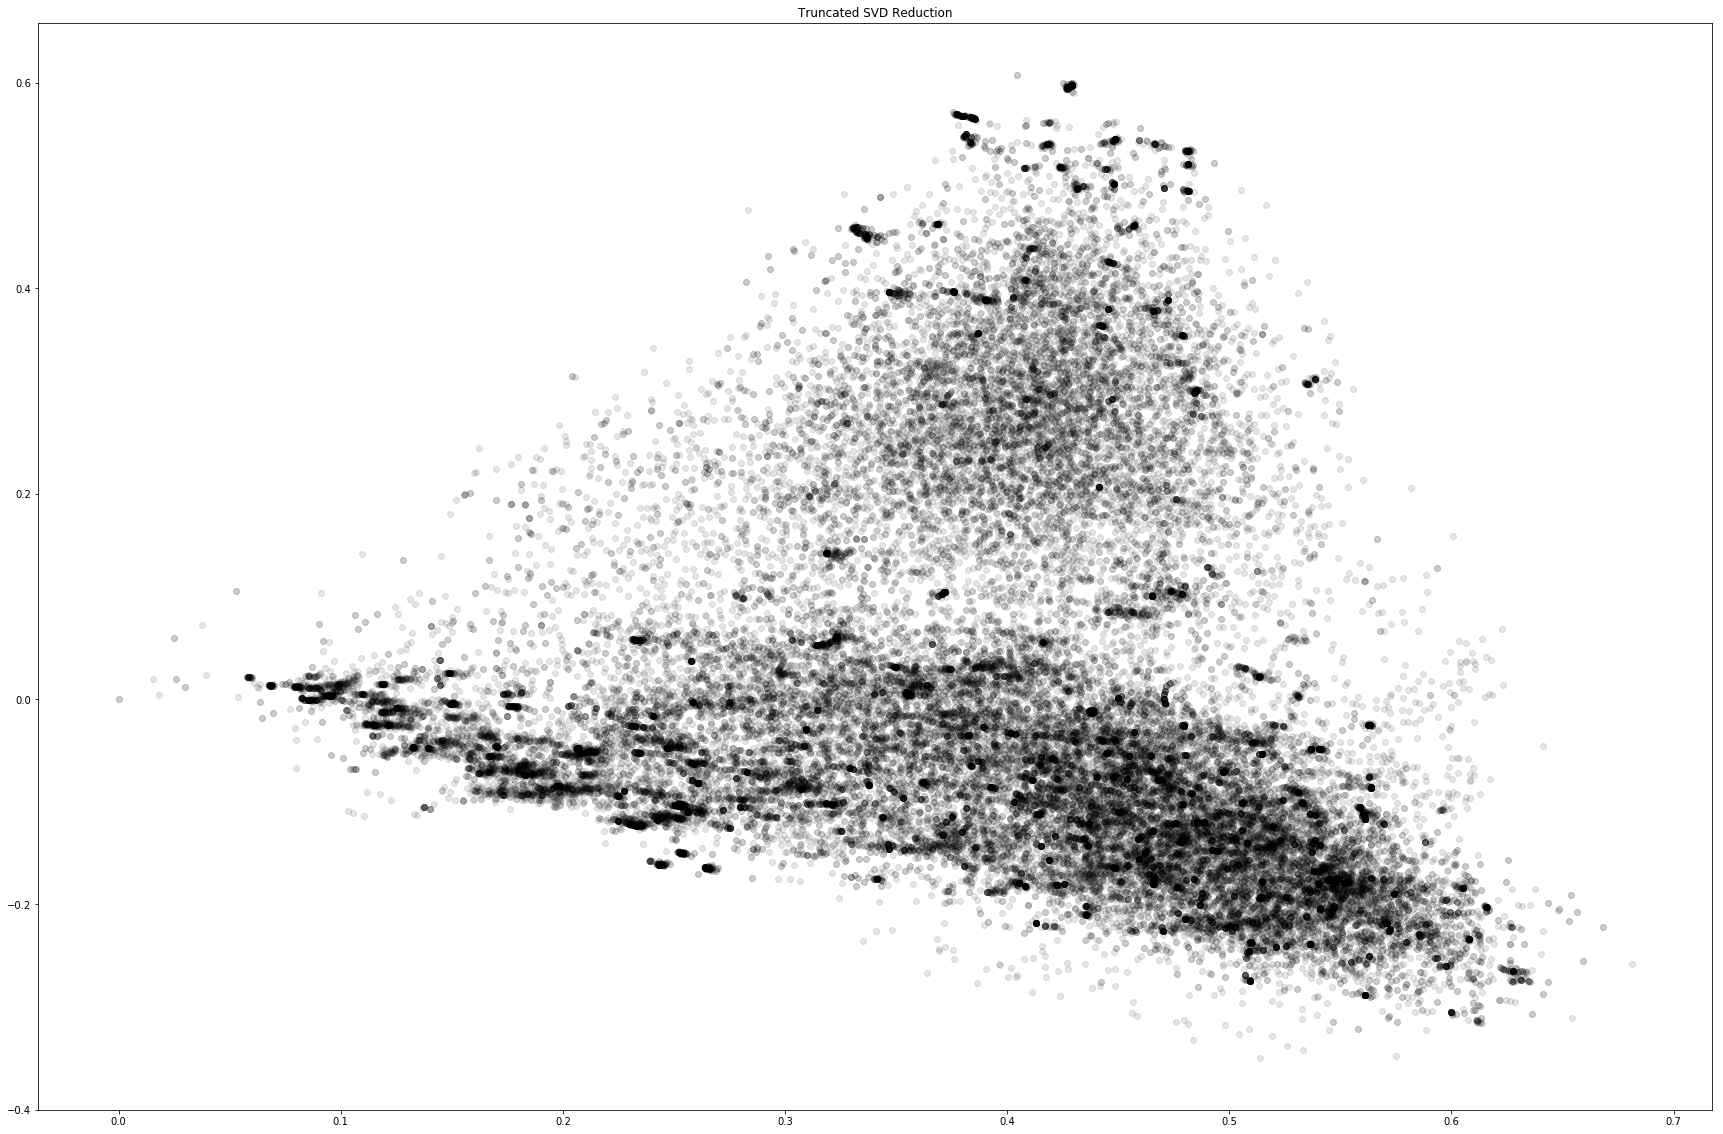

In [16]:
plt.figure(figsize=(30,20))
plt.scatter(clf[:,0], clf[:,1], c='k', alpha=0.1)
plt.title('Truncated SVD Reduction')
plt.show() 

## KMeans

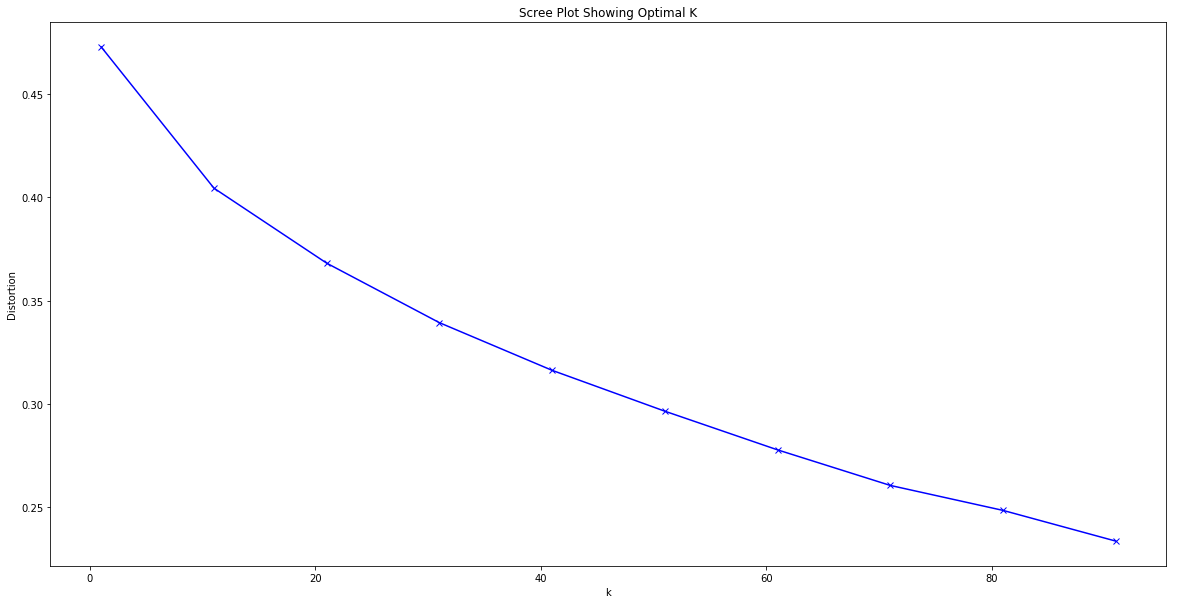

In [66]:
distortions = []
K = range(1,100,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_jobs=-1)
    kmeanModel.fit(clf)
    distortions.append(sum(np.min(cdist(clf, 
                        kmeanModel.cluster_centers_, 
                        'euclidean'), axis=1)) / clf.shape[0])

plt.figure(figsize=(20,10))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Scree Plot Showing Optimal K')
plt.show()

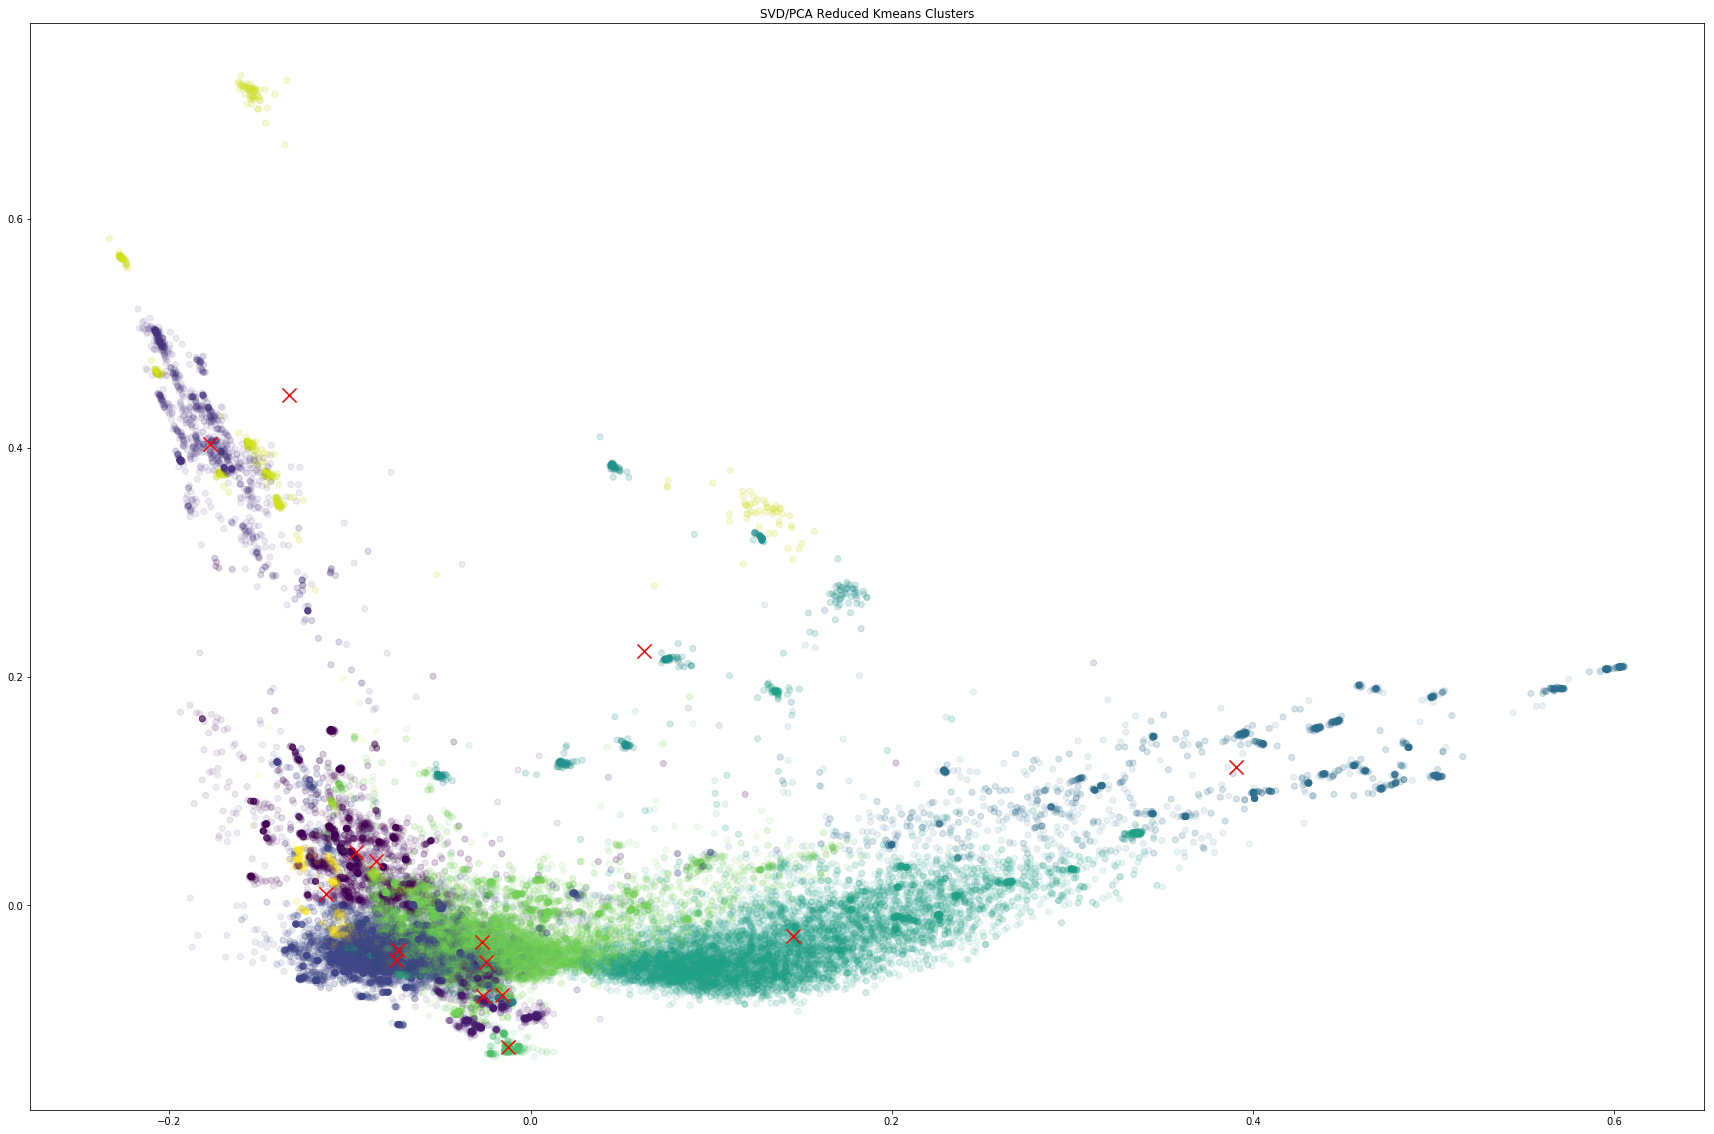

In [64]:
#with SVD n=100 and PCA for visualization

#without max_features
vect = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True) 
tfidf_model = vect.fit_transform(cleaned)

svd1 = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
clf = svd1.fit_transform(tfidf_model) 

num_clusters = 15
km = KMeans(n_clusters=num_clusters, n_jobs=-1) 
km.fit(clf)

clusters = km.labels_.tolist()

pca = PCA(n_components=2).fit(clf)
data2D = pca.transform(clf)
centers2D = pca.transform(km.cluster_centers_)

plt.figure(figsize=(30,20))
plt.scatter(data2D[:,0], data2D[:,1], c=clusters, alpha=0.1)
plt.scatter(centers2D[:,0], centers2D[:,1], marker='x', s=200, linewidths=3, c='r')
plt.title('SVD/PCA Reduced Kmeans Clusters')
plt.show() 

In [65]:
words = vect.get_feature_names()
common_words = km.cluster_centers_.argsort()[:,-1:-500:-1]
# for num, centroid in enumerate(common_words):
#     print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))
check = (', '.join(words[word] for word in common_words[1]))
check

'aabrand, aa, aabsolu, aacloser, aachance, aadrianne, aafortune, aafeblth, aahh, aabused, aacordinglyyno, aaison, aaddi, aafl, aafamily, aaless, aagain, aaffair, aaddyes, aadriver, aadultery, aadda, aaliitle, aalegee, aaccording, aacover, aagin, aagood, aain, aagle, aaerr, aalittll, aaghh, aalk, aaired, aaiens, aaiwering, aaec, aafoomer, aaeas, aage, aallergic, aaloohelps, aaled, aaidr, aaleanance, aais, aaffe, aaddcrrie, aallt, aale, aalabama, aallowing, aacouple, aaea, aahing, aalive, aains, aaid, aaencies, aalloween, aalists, aah, aally, aacuracy, aakth, aagreat, aaliyah, aadd, aaleaguance, aalaa, aalittle, aahiih, aaddit, aad, aake, aabandon, aaghter, aaizona, aaert, aall, aagh, aaead, aaitors, aagala, aaddy, aadpted, aacted, aaby, aacident, aaggressive, aadozen, aadrey, aacoloo, aablege, aabysitter, aachaaity, aaccident, aaccuser, aabout'

## LDA sklearn

In [ ]:
search_params = {'n_components': [5, 25, 50, 100], 
                 'learning_decay': [.5]}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid=search_params)
model.fit(tfidf_model)
best_lda_model = model.best_estimator_

best_lda_model = model.best_estimator_

print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(tfidf_model))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 20}

In [ ]:
best_lda_model = LatentDirichletAllocation(n_components=20, learning_decay=0.5, n_jobs=-1)
best_lda_model.fit(tfidf_model)

/Users/Beto/miniconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [20]:
def show_topics(vectorizer=vectorizer, lda_model=None, n_words=20):
    
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
        
    return topic_keywords

In [21]:
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20)     

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
0,nick,game,team,play,ball,player,coach,season,stephen,field,shot,played,defense,throw,second,pas,third,first,point,last
1,james,cheer applause cheer,applause cheer applause,applause cheer,stephen,defense,announced,judy,kavanaugh,emmy,accused,cloudy,humana,yard,central,katie,chip,football,eye,east
2,accused,defense,flake,announced,applause cheer,nick,cheer applause cheer,applause cheer applause,supreme court,stephen,harvey,katie,allegation,forecast,humana,kavanaugh,brett,mathis,thunderstorm,judy
3,accused,defense,flake,announced,applause cheer,nick,cheer applause cheer,applause cheer applause,supreme court,stephen,harvey,katie,allegation,forecast,humana,kavanaugh,brett,mathis,thunderstorm,judy
4,cheer applause,cheer,applause,applause cheer,applause cheer applause,cheer applause cheer,laughter,audience,welcome back,lady,final,laughter laughter,applause applause,welcome,jimmy,vote,show,song,right back,thank thank
5,accused,defense,flake,announced,applause cheer,nick,cheer applause cheer,applause cheer applause,supreme court,stephen,harvey,katie,allegation,forecast,humana,kavanaugh,brett,mathis,thunderstorm,judy
6,steve,cheering,answer,name,audience,applause,play,harvey,board,everybody,captioning,right back,welcome back,national,supreme court,accused,humana,defense,cheer applause cheer,applause cheer applause
7,murder,case,crime,victim,police,suspect,killed,found,defense,death,husband,information,jimmy,knew,blood,witness,kill,wife,told,dead
8,know,like,right,yeah,okay,want,think,good,going,well,time,come,back,love,look,really,thing,little,would,need
9,cardi,kanye,married,york,trump,video,donald,president,club,weekend,strip,wedding,show,said,chris,west,stage,source,come back,speaking


Text(0.5,1,'LDA/KMeans Topic Clusters via 2 Component SVD')

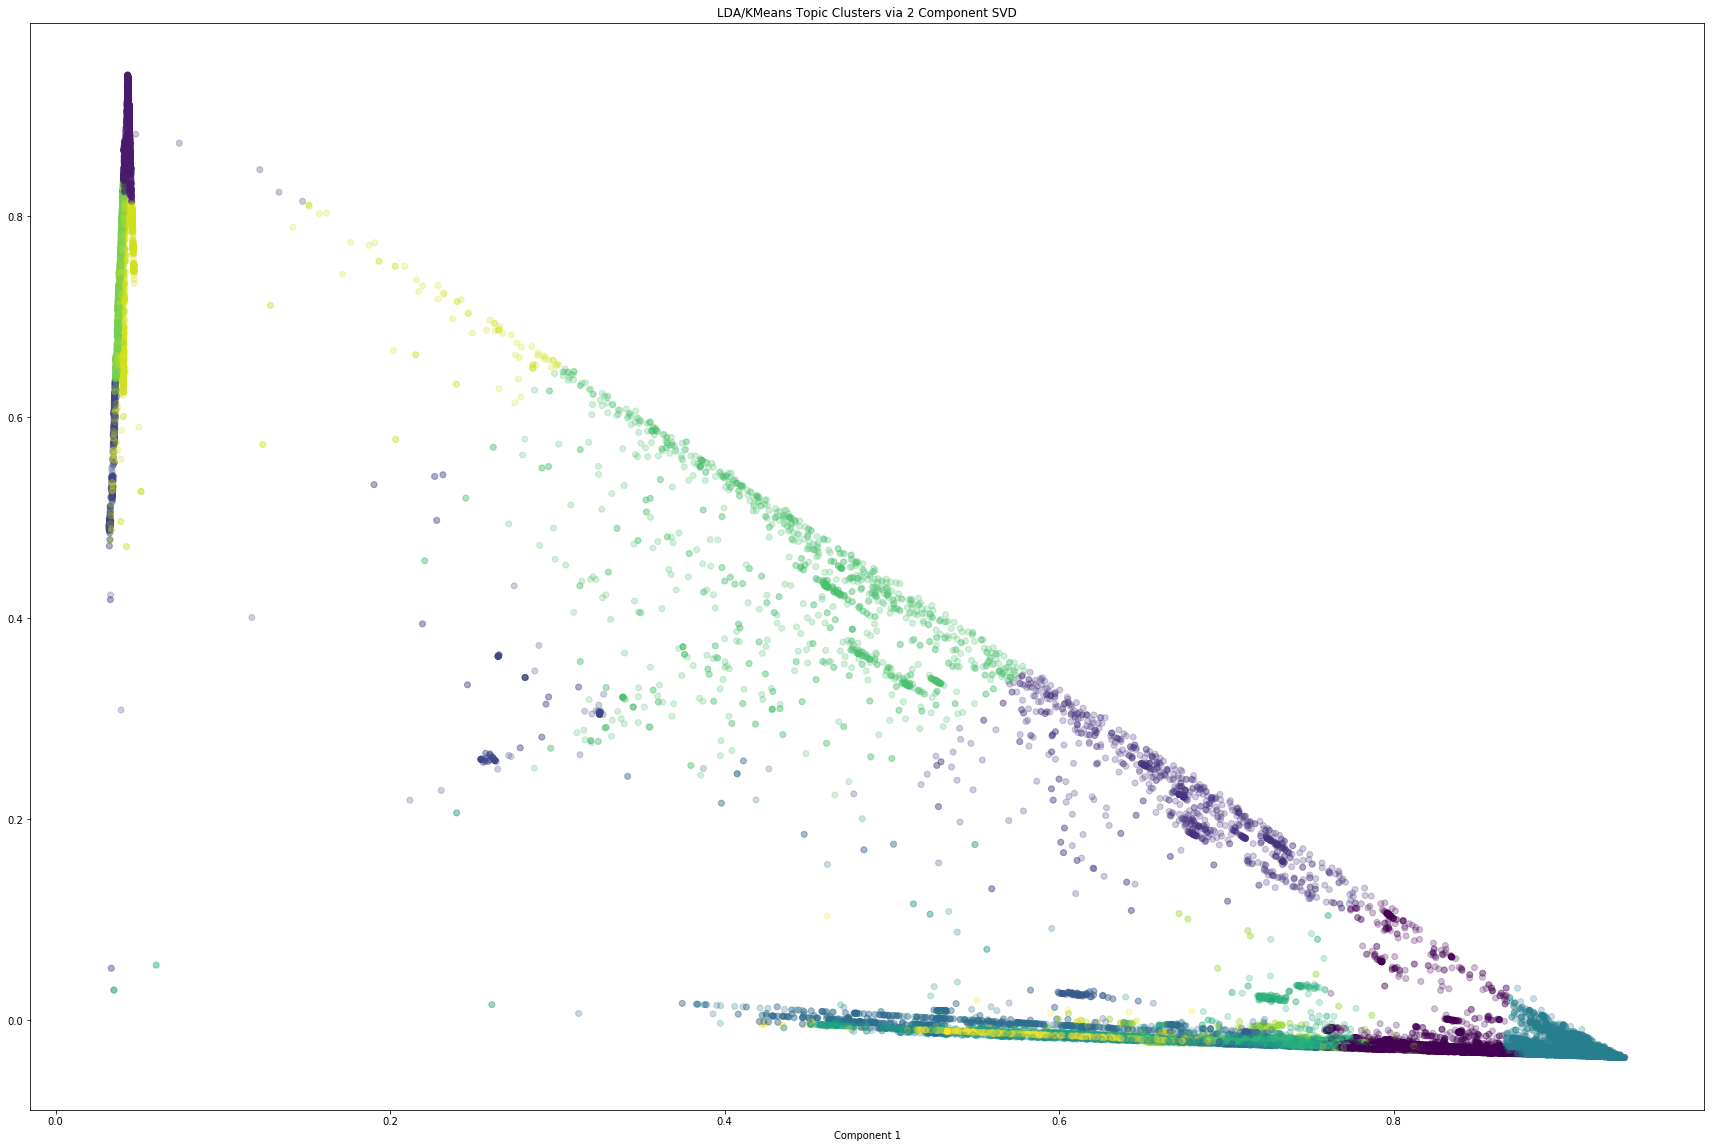

In [22]:
lda_output = best_lda_model.transform(tfidf_model)
clusters = KMeans(n_clusters=15, random_state=100, 
                  n_jobs=-1, verbose=False).fit_predict(lda_output)

svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
clf = svd.fit_transform(lda_output)

plt.figure(figsize=(30,20))
plt.scatter(clf[:, 0], clf[:, 1], c=clusters, alpha=0.25)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("LDA/KMeans Topic Clusters via 2 Component SVD")

## Word Distribution

In [47]:
vec = TfidfVectorizer(stop_words=stopwords.words('english'), 
                     lowercase=True, ngram_range=(1,3), max_features=1000) 
tfidf_model = vec.fit_transform(text)

plot_lda_model = LatentDirichletAllocation(n_components=20, 
                                           learning_decay=0.5, n_jobs=-1)
lda_model = plot_lda_model.fit(tfidf_model)

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(plot_lda_model, tfidf_model, vec)

In [2]:
from IPython.display import HTML

file = HTML(filename="data/lda.html")
file

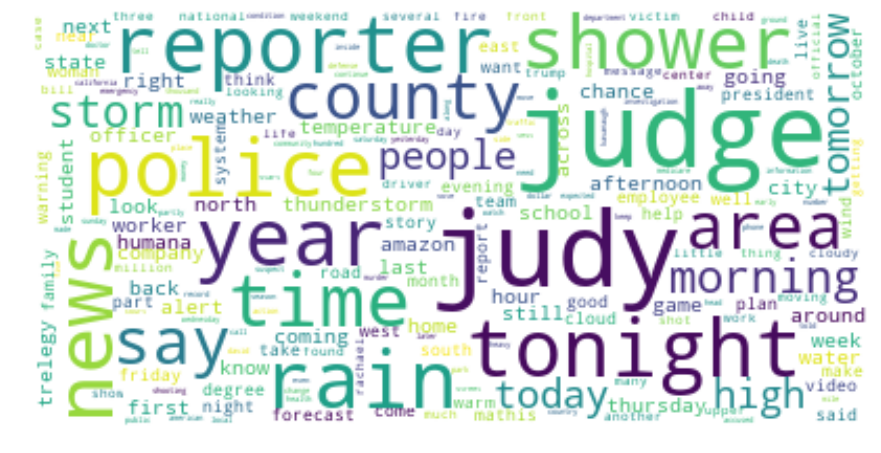

In [88]:
def display_topics(model, feature_names, no_top_words):
    keys = []
    for topic_idx, topic in enumerate(model.components_):
        keys.append(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    return keys
        
feature_names = vec.get_feature_names()
no_top_words = 200
keywords = display_topics(best_lda_model, feature_names, no_top_words)
wordcloud = WordCloud(background_color="white",max_font_size=50).generate(keywords[16])
plt.figure(figsize=(15, 40))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Sentiment Analysis with spaCy and VADER

In [65]:
with open("brand_list.txt") as f:
    brands = f.read().replace('\n', '').lower()
    
#use replace instead of str.maketrans for special characters
brands = list(brands.replace("'", '').replace('[', '').replace(']', '').replace('\"','').replace('-', '').split(', '))
brands = [x.capitalize() for x in brands]
print(brands)

['Accenture', 'Adidas', 'Adobe', 'Agricultural bank of china', 'Aia', 'Aldi', 'Alibaba', 'Amazon', 'American express', 'Anz', 'Apple', 'At&t', 'Baidu', 'Bank of america', 'Bank of china', 'Bca', 'Bmw', 'Budweiser', 'Chase', 'China construction bank', 'China life', 'China mobile', 'Cisco', 'Citi', 'Cocacola', 'Colgate', 'Commonwealth bank of australia', 'Costco', 'Deutsche telekom', 'Dhl', 'Disney', 'Ebay', 'Exxonmobil', 'Facebook', 'Fedex', 'Ford', 'Ge', 'Gillette', 'Google', 'Gucci', 'Hdfc bank', 'Hermès', 'Honda', 'Hp', 'Hsbc', 'Huawei', 'Ibm', 'Icbc', 'Ikea', 'Instagram', 'Intel', 'Jp morgan', 'Jd.com', 'Kfc', 'Loréal paris', 'Linkedin', 'Louis vuitton', 'Lowes', 'Marlboro', 'Mastercard', 'Mcdonalds', 'Mercedes benz', 'Microsoft', 'Moutai', 'Movistar', 'Netflix', 'Nike', 'Ntt', 'Oracle', 'Orange', 'Pampers', 'Paypal', 'Pepsi', 'Rbc', 'Salesforce', 'Samsung', 'Sap', 'Shell', 'Siemens', 'Spectrum', 'Starbucks', 'Subway', 'Tencent', 'The home depot', 'Toyota', 'Uber', 'Ups', 'Us bank',

In [66]:
len(brands)

173

In [ ]:
def get_sentiment_sentence(sent_tok, brands):
    
    analyser = SentimentIntensityAnalyzer()
    scores = []
    
    for brand in brands:
        for sent in sent_tok:
            if brand in sent:
                score = list(dict.items(analyser.polarity_scores(sent)))
                scores.append([brand, score])
          
    return scores

In [95]:
with open ('data/sentiments.pkl', 'rb') as r:
     sentiments = pickle.load(r)
sentiments[6:10]

[['Xfinity',
  [('neg', 0.0), ('neu', 0.882), ('pos', 0.118), ('compound', 0.4939)]],
 ['Nintendo',
  [('neg', 0.103), ('neu', 0.653), ('pos', 0.243), ('compound', 0.497)]],
 ['Nintendo', [('neg', 0.0), ('neu', 1.0), ('pos', 0.0), ('compound', 0.0)]],
 ['Allstate', [('neg', 0.0), ('neu', 1.0), ('pos', 0.0), ('compound', 0.0)]]]

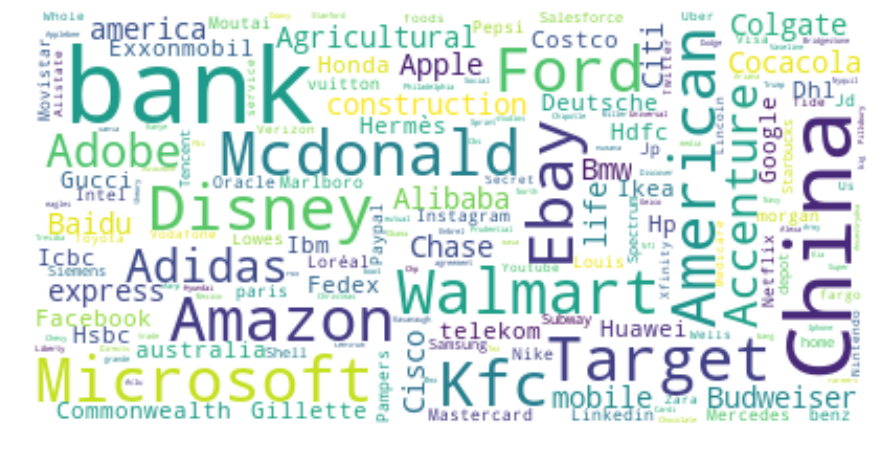

In [97]:
wordcloud = WordCloud(background_color="white",max_font_size=50).generate(" ".join(brands))
plt.figure(figsize=(15, 40))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
sentiment_array = [(sent[0], sent[1][0][1], sent[1][2][1]) for sent in sentiments]
sentiment_df = pd.DataFrame(sentiment_array, columns=['label', 'neg','pos'])
#sentiment_df.to_csv('data/sentiment_df.csv')

In [23]:
sentiments = pd.read_csv('data/sentiment_df.csv')
sentiments.head()

,label,neg,pos
0,Farmers,0.000,0.0
1,Farmers,0.000,0.0
2,Allstate,0.000,0.0
3,Allstate,0.167,0.0
4,Netflix,0.000,0.0


In [44]:
grouped = sentiments.groupby(['label'], as_index=False).mean()
grouped.head()

,label,neg,pos
0,Adidas,0.033769,0.105615
1,Adobe,0.218750,0.062750
2,Alexa,0.009995,0.089558
3,Allstate,0.093566,0.086681
4,Amazon,0.039782,0.191435


In [59]:
negative = grouped[['label', 'neg']]
negative.head()

,label,neg
0,Adidas,0.033769
1,Adobe,0.218750
2,Alexa,0.009995
3,Allstate,0.093566
4,Amazon,0.039782


In [60]:
positive = grouped[['label', 'pos']]
positive.head()

,label,pos
0,Adidas,0.105615
1,Adobe,0.062750
2,Alexa,0.089558
3,Allstate,0.086681
4,Amazon,0.191435


In [61]:
pos = positive.sort_values(by=['pos'], ascending=False)
pos

,label,pos
13,Chocolate,0.299703
40,Iphone,0.290190
39,Intel,0.286590
37,Ikea,0.252778
51,Microsoft,0.213516
70,Spectrum,0.210625
61,Pampers,0.196573
4,Amazon,0.191435
57,Nintendo,0.173199
26,Fedex,0.165529


In [62]:
neg = negative.sort_values(by=['neg'], ascending=False)
neg

,label,neg
46,Lowes,0.524440
23,Enbrel,0.300529
43,Kia,0.250916
1,Adobe,0.218750
77,Toyota,0.215513
18,Costco,0.166583
73,Starbucks,0.139896
60,Oracle,0.123286
58,Nyquil,0.104000
3,Allstate,0.093566


## Most Positive Brands

In [63]:
print(pos.head(10))

        label       pos
13  Chocolate  0.299703
40     Iphone  0.290190
39      Intel  0.286590
37       Ikea  0.252778
51  Microsoft  0.213516
70   Spectrum  0.210625
61    Pampers  0.196573
4      Amazon  0.191435
57   Nintendo  0.173199
26      Fedex  0.165529


## Most Negative Brands

In [64]:
print(neg.head(10))

        label       neg
46      Lowes  0.524440
23     Enbrel  0.300529
43        Kia  0.250916
1       Adobe  0.218750
77     Toyota  0.215513
18     Costco  0.166583
73  Starbucks  0.139896
60     Oracle  0.123286
58     Nyquil  0.104000
3    Allstate  0.093566
